In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

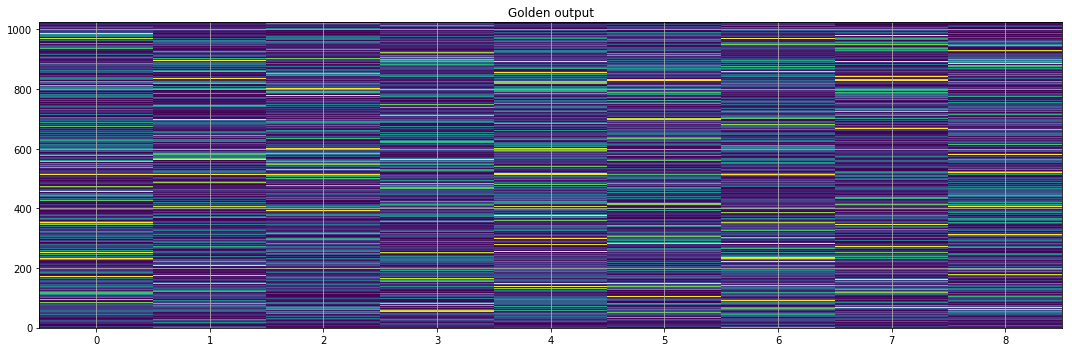

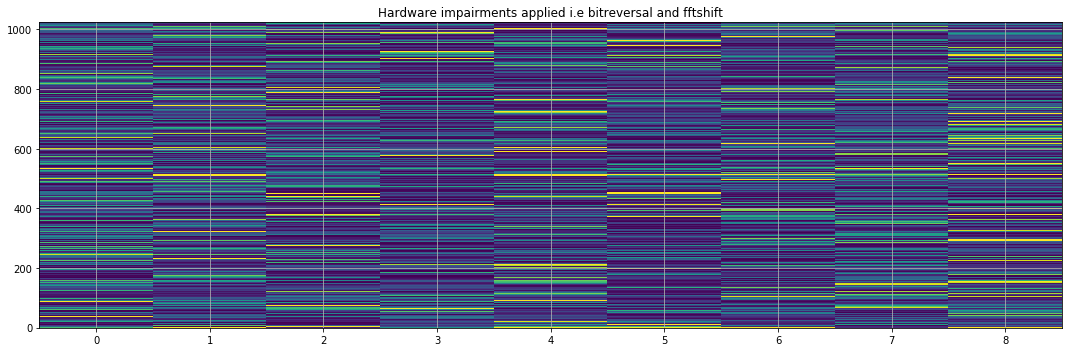

In [2]:
from pyhacores.utils import *
from scipy import signal
fft_size = 1024
avg_freq_axis = 1
file = '/home/gaspar/git/pyhacores/data/low_power_ph3.raw'
# orig_inp = load_iq(file)[2120000:2800000]
orig_inp = load_iq(file)[2120000:2130000]

orig_inp -= np.mean(orig_inp)
# orig_inp = orig_inp[:len(orig_inp)//8]

_, _, spectro_out = signal.spectrogram(orig_inp, 1, nperseg=fft_size, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_size//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // avg_freq_axis)
golden_output = np.average(x, axis=1)

plt.title('Golden output')
imshow(golden_output)

plt.title('Hardware impairments applied i.e bitreversal and fftshift')
from pyhacores.fft.util import toggle_bit_reverse

input_signal = toggle_bit_reverse(spectro_out.T).T
input_signal = np.fft.fftshift(input_signal)
imshow(input_signal)

## Fix bitreversal and fftshift

In [14]:
from pyhacores.fft import BitreversalFFTshiftAVGPool
from pyhacores.fft.packager import DataWithIndex, unpackage, package
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=2, avg_time_axis=1)
fft_sims = simulate(dut, input_signal.T, input_types=[Complex(0, 0, -35)], output_callback=unpackage, input_callback=package, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...


IndexError: list index out of range

In [6]:
snr(fft_sims['MODEL'], fft_sims['PYHA'])

AttributeError: 'list' object has no attribute 'T'

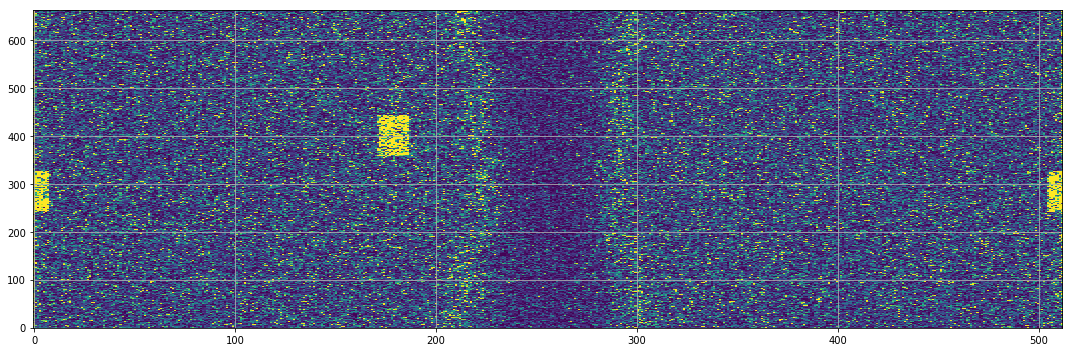

In [10]:
imshow(fft_sims['MODEL'])

In [12]:
fft_sims['PYHA']

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [ ]:
plt.title('Output - real part')
# for key, value in sims.items():
plt.plot(np.array(sims['MODEL']).flatten())
plt.plot(np.array(sims['PYHA']).flatten())
plt.plot(input_signal)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
# plt.ylim([-120, 1])
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [ ]:
print(f'Minimum number representabe: {2**-17}')

## Coefficients are stored as constants in LUTs
Storing 18bit coefficnets for large FFT can take huge amounts of LUTS. I recommend using bitwidth of ~8, this gives quite optimal packing. Note that ~8 bit coefficents might look bad on synthetic signals but are acutally very much usable on real-life signals.

## Output ordering is different from numpy
Numpy has `Natural(in) -> Natural(out)` ordering. These cores provide either `Natural -> Bitreversed` or `Bitreversed -> Natural` ordering.

## Scaling is different from numpy
Numpy scales `fft_out *= FFT_LENGHT` and `ifft_out /= FFT_LENGHT`. 

This core works in oppsite i.e. `fft_out /= FFT_LENGHT` and `ifft_out *= FFT_LENGHT`.

# Synthesis

## FFT 256

In [ ]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(fft_256, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

In [ ]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')

## IFFT 256

In [ ]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(ifft_256, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

In [ ]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')